In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [261]:
d = 6 #dimension of theta
theta_star = np.ones((d))/3  #optimal point

In [208]:
def treat_outcome(theta,M):   #the average outcome of M samples at theta
    tmp = np.exp(-np.sum((theta-theta_star)**2)*0.1-2)
    prob = tmp/(1+tmp)
    res = np.sum(np.random.binomial(size=M,n=1,p=prob))/M 
    return res

In [239]:
def zeroth_order_opt(total_iter,M,d,rho,stepsize_cons): #M=m/10 in paper, stepsize_cons=C_0 in paper
    sum_of_outcome = 0
    theta = np.ones((d))/2
    theta_list = []
    value_est = np.zeros((total_iter))
    for t in range(total_iter):
        c = (t+1)**(-1/5)
        tmp_min = min(min(theta),min(1-theta))
        c = min(c,tmp_min)
        w = np.random.normal(size = d)
        w = w/np.sqrt(np.sum(w**2))           #this is not uniformly sampled from uniform ball, but it also works
        theta_plus_1 = theta+c*w
        theta_minus_1 = theta-c*w
        theta_plus_2 = theta+3*c*w
        theta_minus_2 = theta-3*c*w
        mu_tmp_1 = treat_outcome(theta_plus_1,9*M)
        mu_tmp_0 = treat_outcome(theta_minus_1,9*M)
        mu_tmp_3 = treat_outcome(theta_plus_2,M)
        mu_tmp_2 = treat_outcome(theta_minus_2,M)
        value_est[t] = 9*(mu_tmp_1+mu_tmp_0)/16-(mu_tmp_3+mu_tmp_2)/16
        sum_of_outcome += value_est[t]
        grad_est = (-mu_tmp_3+mu_tmp_2+27*mu_tmp_1-27*mu_tmp_0)/(48*c)*w
        theta = theta+grad_est*stepsize_cons/((t+1)**(1-rho))
        for i in range(d):
            if theta[i]<0.01:
                theta[i] = 0.01
            if theta[i]>0.99:
                theta[i] = 0.99
        theta_list.append(theta)
    return sum_of_outcome,theta,value_est,theta_list

In [ ]:
T = 100000
M = 10
tot_sample = T*M*20 #tot_sample, instead of T, is the total number of samples in our experiment
sum_of_outcome,theta_hat,value_est,theta_list = zeroth_order_opt(T,M,d,0.0,20)
print(theta_star,theta_hat,np.sum(theta_hat-theta_star)**2)

In [247]:
clt_iter = 200
clt_res = np.zeros((clt_iter))
for j in range(clt_iter):
    sum_of_outcome,theta_hat,value_est,theta_list = zeroth_order_opt(T,M,d,0,20)
    theta_list = np.array(theta_list)
    clt_tot  = 0
    sum_of_clt = 0
    theta_ave = 0
    for i in range(T):
        if (i>0.9*T):  #beta = 0.1
            theta_ave += theta_list[i]
    theta_ave = theta_ave/(0.1*T-1)
    for i in range(T):
        if np.sum((theta_list[i,:]-theta_ave)**2)<1e-4:   #we here use those samples which are near theta_hat for our CLT. This can be removed.
            clt_tot+=1
            sum_of_clt += value_est[i]
    tmp = np.exp(-np.sum((theta_ave-theta_star)**2)*0.1-2)
    mu_ave = tmp/(1+tmp)
    clt_res[j] = np.sqrt(clt_tot*M*20)*(sum_of_clt/clt_tot-mu_ave)/(np.sqrt(v_star)*5/4)

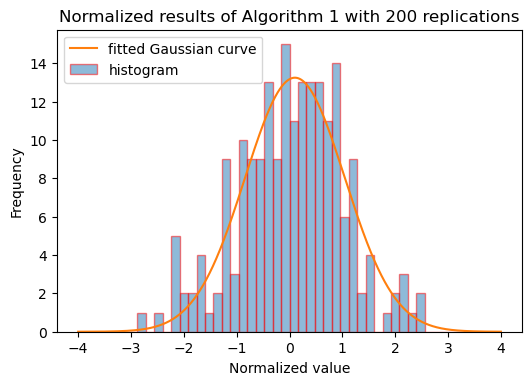

In [262]:
from scipy.optimize import curve_fit
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

plt.figure(dpi = 100)
bin_heights, bin_borders, _ = plt.hist(clt_res,range=(-4,4),bins=50, label='histogram',edgecolor='r',alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fitted Gaussian curve')
plt.xlabel('Normalized value')
plt.ylabel('Frequency')
plt.title('Normalized results of Algorithm 1 with 200 replications')
plt.legend()
plt.savefig('za_2')

In [257]:
num = clt_res.size
mean = np.sum(clt_res)/num
sd = np.sqrt(np.sum((clt_res-mean)**2)/num)
CI = np.sum(abs(clt_res)<1.96)/num
print(num,mean,sd,CI)

100 0.0012103603482536318 0.950547202000604 0.94
